In [33]:
import tensorflow as tf
# import tensorflow.keras as keras
import evoaug_tf
from evoaug_tf import evoaug, augment 
import keras
from keras.models import load_model
import numpy as np
import sys
import yaml
import seaborn as sns
import h5py
import pandas as pd
import pickle
sys.path.append('../code')
from utils import load_DeepSTARR_data
from model_zoo import DeepSTARR
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

# set seeds
tf.random.set_seed(1)
np.random.seed(1)

In [58]:
def shuffle_channels(tensor):
    # Get the shape of the input tensor
    N, L, C = tf.shape(tensor)[0], tf.shape(tensor)[1], tf.shape(tensor)[2]
    
    # Create indices for shuffling
    indices = tf.range(C)
    
    # Tile and reshape indices to match the shape of the input tensor
    tiled_indices = tf.tile(tf.expand_dims(indices, 0), [N * L, 1])
    
    # Shuffle the tiled indices
    shuffled_indices = tf.random.shuffle(tiled_indices)
    
    # Reshape the shuffled indices to match the input tensor shape
    shuffled_indices = tf.reshape(shuffled_indices, [N, L, C])
    
    # Use tf.gather with the shuffled indices to reorder the channel axis
    shuffled_tensor = tf.gather(tensor, shuffled_indices, batch_dims=2)
    
    return shuffled_tensor


In [65]:
class RandomShuffle(augment.AugmentBase):
    def __init__(self):
        pass

    def __call__(self, x):
        N = tf.shape(x)[0]
        x_mut = tf.TensorArray(dtype=x.dtype, size=N, element_shape=x[0].shape)
        body = lambda i, x_mut: (i + 1, x_mut.write(i, tf.random.shuffle(x[i])))
        cond = lambda i, x_mut: i < N
        _, x_mut = tf.while_loop(cond, body, [0, x_mut])
        return x_mut.stack()

# Load data

In [66]:
data = '../data/DeepSTARR_ensemble_NEW/all_data_with_ensemble_metrics_hierarchical.h5'
X_train, y_train, X_test, y_test, X_val, y_val = load_DeepSTARR_data(data, std=True)

loading data from h5 file with hierarchical structure


In [67]:
# cast as tensor 
X_test_tf = tf.cast(X_test, tf.float32)

# Random shuffling

In [70]:
random_shuffle = RandomShuffle()
X_test_shuffled = random_shuffle(X_test_tf).numpy()

# Predict

In [75]:
model_file = '../results/DeepSTARR_ensemble_NEW/1_DeepSTARR.h5'
model = load_model(model_file)

In [76]:
orig_preds = model.predict(X_test)

1288/1288 [==============================] - 3s 3ms/step


In [77]:
shuff_preds = model.predict(X_test_shuffled)

1288/1288 [==============================] - 3s 2ms/step


In [78]:
# Pickle 
preds_dict = {'starrseq': orig_preds,
              'shuffled': shuff_preds}

with open('../data/DeepSTARR/orig_vs_shuffled_preds.pickle', 'wb') as fh:
    pickle.dump(preds_dict, fh)

# Plot 

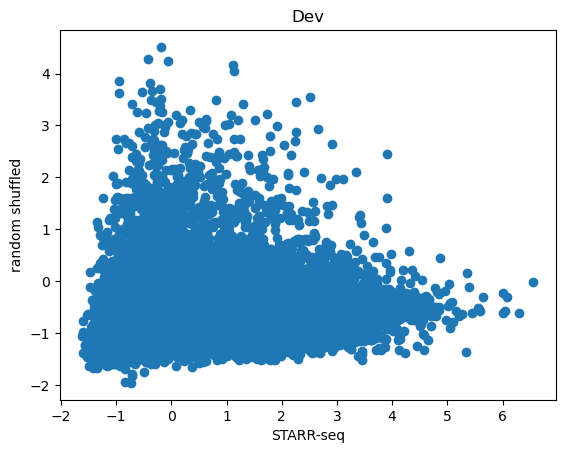

In [79]:
plt.scatter(x=orig_preds[:,0], y=shuff_preds[:,1])
plt.xlabel('STARR-seq')
plt.ylabel('random shuffled')
plt.title('Dev')
plt.show()

(array([3.9690e+03, 1.5864e+04, 1.0178e+04, 6.1950e+03, 3.2330e+03,
        1.2480e+03, 3.7700e+02, 9.7000e+01, 1.9000e+01, 6.0000e+00]),
 array([-1.61319649, -0.79636544,  0.02046566,  0.83729672,  1.65412784,
         2.47095895,  3.28779006,  4.10462093,  4.92145205,  5.73828316,
         6.55511427]),
 <BarContainer object of 10 artists>)

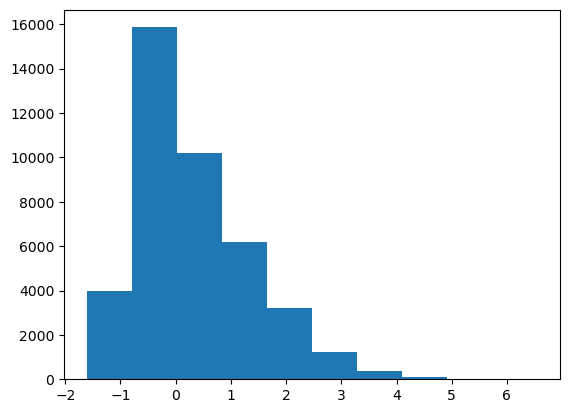

In [80]:
plt.hist(orig_preds[:,0])

In [82]:
orig_preds[:,0]

array([ 1.6709914 ,  1.2511635 ,  2.7184052 , ...,  0.35867184,
        0.09162565, -0.34706855], dtype=float32)

In [83]:
shuff_preds[:,0]

array([-0.2830875 , -1.0280596 ,  0.5462172 , ..., -0.06385136,
       -0.62761515, -0.43540496], dtype=float32)

In [84]:
orig_preds[:,0]

array([ 1.6709914 ,  1.2511635 ,  2.7184052 , ...,  0.35867184,
        0.09162565, -0.34706855], dtype=float32)

(array([5.0350e+03, 1.9420e+04, 1.1145e+04, 3.7180e+03, 1.3380e+03,
        4.0400e+02, 9.9000e+01, 2.0000e+01, 5.0000e+00, 2.0000e+00]),
 array([-1.49712813, -0.84786761, -0.19860706,  0.45065346,  1.09991395,
         1.74917459,  2.39843512,  3.04769564,  3.69695616,  4.34621668,
         4.9954772 ]),
 <BarContainer object of 10 artists>)

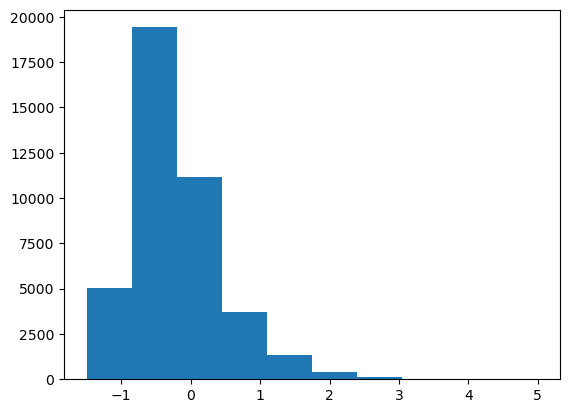

In [85]:
plt.hist(shuff_preds[:,0])

<Axes: xlabel='prediction', ylabel='Count'>

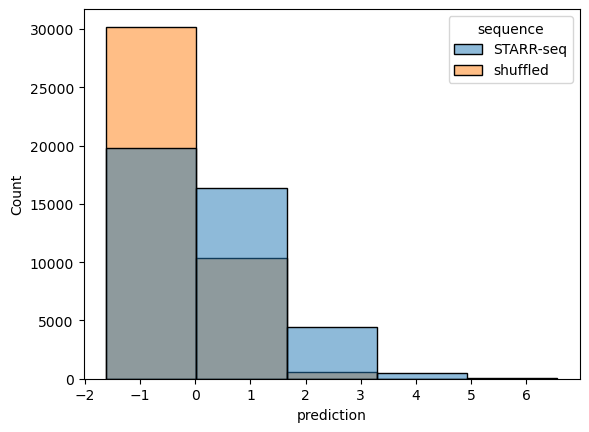

In [86]:
hist_df = pd.DataFrame({'STARR-seq': orig_preds[:,0],
                        'shuffled': shuff_preds[:,0]})

hist_df = hist_df.melt(var_name='sequence', value_name='prediction')
sns.histplot(hist_df, x='prediction', hue='sequence', bins=5)


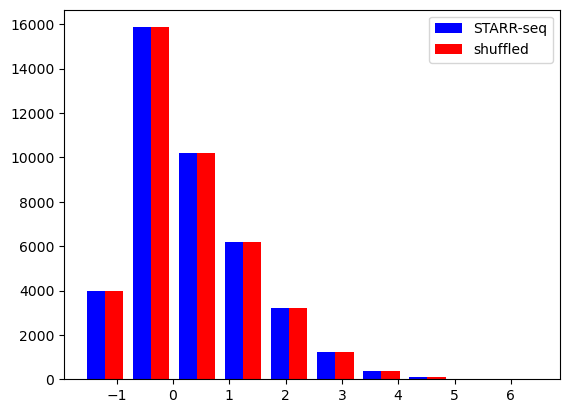

In [44]:
import matplotlib.pyplot as plt

# Define colors
colors = ['blue', 'red']

plt.hist([orig_preds[:,0], shuff_preds[:,0]], label=['STARR-seq', 'shuffled'], color=colors)
plt.legend()
plt.show()

In [20]:
shuff_preds==orig_preds

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])